In [1]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2021-06-21 00:08:37--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: 'airline_passengers.csv'

     0K .                                                     100% 4.47M=0s

2021-06-21 00:08:37 (4.47 MB/s) - 'airline_passengers.csv' saved [2036/2036]



In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
df.isna().sum()

Passengers    0
dtype: int64

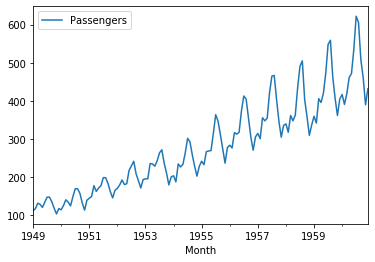

In [6]:
df.plot();

In [10]:
alpha = 0.2

In [11]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [12]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.EWM

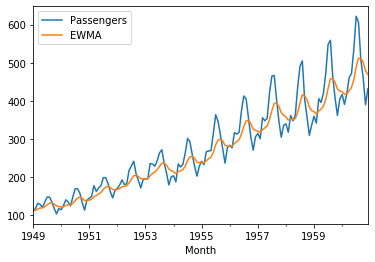

In [13]:
df.plot();

In [14]:
manual_ewma = []
for x in df['Passengers'].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['Manual'] = manual_ewma

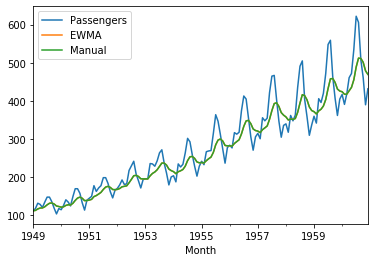

In [15]:
df.plot();

In [16]:
df.head()

,Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [17]:
df.drop('Manual', axis=1, inplace=True)

### now move on to SimpleExpSmoothing
* does not simply calculate Exp moving average
* it treated as a forecast model 
* use statemodels 

In [18]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [19]:
ses = SimpleExpSmoothing(df['Passengers'])

C:\Anaconda3\envs\py36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [20]:
# link to offset aliases docs
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [21]:
df.index.freq = 'MS'

### MS means "month"

In [22]:
ses = SimpleExpSmoothing(df['Passengers'])

### after fix freq in index, no more warning 

In [33]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [34]:
res

In [35]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [36]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [37]:
np.allclose(df['SES'], res.fittedvalues)

True

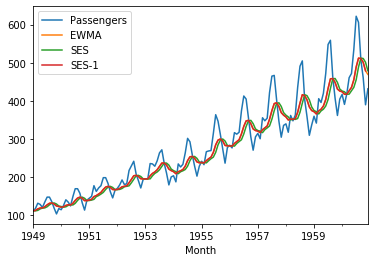

In [38]:
df.plot();

In [39]:
df.head()

,Passengers,EWMA,SES,SES-1
Month,,,,
1949-01-01,112,112.0000,112.000,112.0000
1949-02-01,118,113.2000,112.000,113.2000
1949-03-01,132,116.9600,113.200,116.9600
1949-04-01,129,119.3680,116.960,119.3680
1949-05-01,121,119.6944,119.368,119.6944


In [40]:
df['SES-1'] = df['SES'].shift(-1)

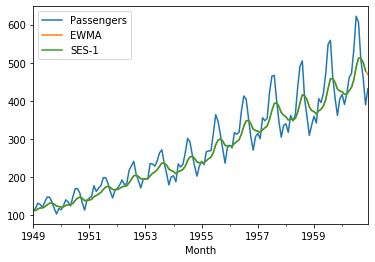

In [41]:
### No!
df[['Passengers', 'EWMA', 'SES-1']].plot();

### NO  means can not do this.  This is Winter model.. 
* it use y(t), yhat(t) to predict yhat(t+1), so, the index is off one 

### Use SimpleExpSmoothing for train and forecasting 
* it turned out the alpha = 1.. simply copy previous value 

In [42]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [43]:
ses = SimpleExpSmoothing(train['Passengers'])
res = ses.fit()

C:\Anaconda3\envs\py36\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [44]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

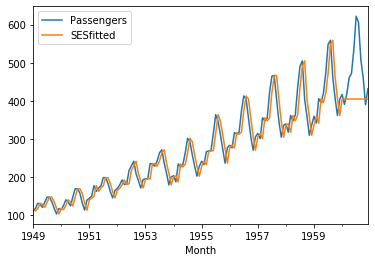

In [45]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot();

In [46]:
res.params

{'smoothing_level': 1.0,
 'smoothing_slope': nan,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 112.00238535353937,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

### Holt model 

In [47]:
from statsmodels.tsa.holtwinters import Holt

In [48]:
holt = Holt(df['Passengers'])

In [49]:
res_h = holt.fit()

C:\Anaconda3\envs\py36\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [53]:
df['Holt'] = res_h.fittedvalues

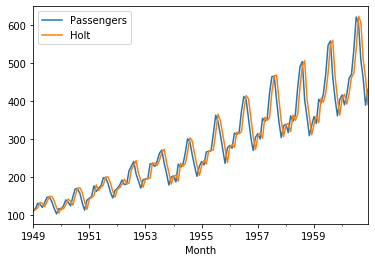

In [54]:
df[['Passengers', 'Holt']].plot();

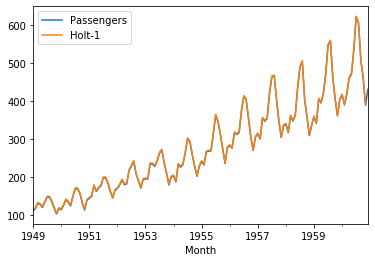

In [55]:
### No!
df['Holt-1'] = df['Holt'].shift(-1)
df[['Passengers', 'Holt-1']].plot();

In [56]:
holt = Holt(train['Passengers'])
res_h = holt.fit()
df.loc[train_idx, 'Holt'] = res_h.fittedvalues

C:\Anaconda3\envs\py36\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [57]:
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

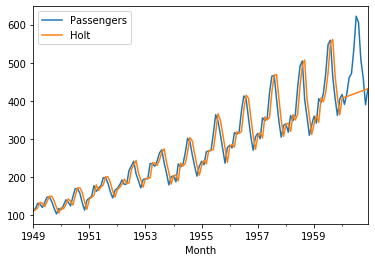

In [58]:
df[['Passengers', 'Holt']].plot();

### add seasonal model 

In [59]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### let's try additive model 

In [60]:
hw = ExponentialSmoothing(train['Passengers'], \
                          trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

C:\Anaconda3\envs\py36\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Anaconda3\envs\py36\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Anaconda3\envs\py36\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [61]:
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues

In [62]:
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

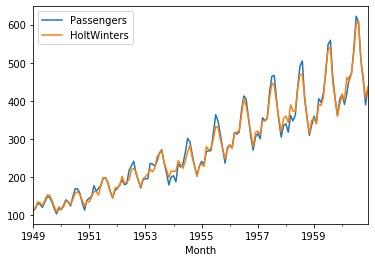

In [63]:
df[['Passengers', 'HoltWinters']].plot();

In [64]:
def rmse(y, t):
  return np.sqrt(np.mean((y - t)**2))

In [65]:
def mae(y, t):
  return np.mean(np.abs(y - t))

In [66]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.862179068213173
Test RMSE: 15.570830479207405


In [67]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 8.942367336934467
Test MAE: 10.455563689642963


### let's try additive trend, and  multiplicative seasonal  model 

C:\Anaconda3\envs\py36\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Anaconda3\envs\py36\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Anaconda3\envs\py36\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


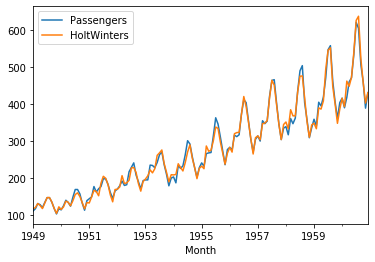

In [68]:
hw = ExponentialSmoothing(train['Passengers'], \
                          trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [69]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 10.083139054511385
Test RMSE: 17.485688894193892


In [70]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.504082801980351
Test MAE: 11.288272571871564


### let's try multiplciative for both trend and seasonal 

C:\Anaconda3\envs\py36\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Anaconda3\envs\py36\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


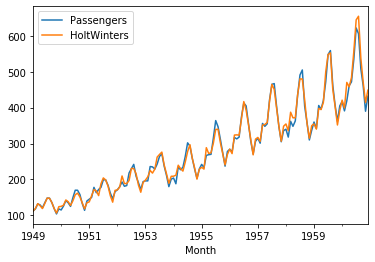

In [71]:
hw = ExponentialSmoothing(train['Passengers'], \
                          trend='mul', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [72]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.61792483064889
Test RMSE: 25.80999128246843


In [73]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.112494568851915
Test MAE: 20.847917679593667
